# Doosan's 6DOF robotic arm example
This example demonstrate a simple robotic arm operation scenario.
We simulating an operation room with a robotic arm which suppose to locate some tool on a patient back. 

The setpoints on the patient back decided by a camera mounted on the tip. 

In general, the system can be described by the following diagram:

![](https://user-images.githubusercontent.com/58637596/212657304-a5810ce0-6d53-4421-ad43-e95a53379965.png)


We want to test the arm trajectories based on normal distributed tip setpoints:

$$ x_{est} =  normal(x_{true}, \sigma) $$
$$ y_{est} =  normal(y_{true}, \sigma) $$
$$ z_{est} =  normal(z_{true}, \sigma) $$

The 6DOF control is based on [ros2-control](https://control.ros.org/master/index.html) library and includes both joints control and trajectory controller.

This file contains both markdown cell for verbal explanations and python cells for analyzing the results.

Importing necessary packages

In [27]:
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

Parsing the `json` file:

In [30]:
file = 'data/b9f40c8b-692c-4026-b90a-42785529b8e5.json'
x = []
y = []
z = []

with open(file) as f:
    db = json.load(f)

for i in range(len(db)):
    x.append(db[i]['data']['pose'][9]['position']['x'])
    y.append(db[i]['data']['pose'][9]['position']['y'])
    z.append(db[i]['data']['pose'][9]['position']['z'])

After Extracting the tip position, we can plot the trajectory:

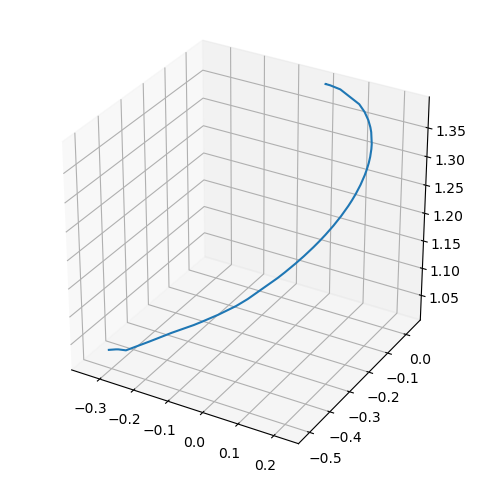

In [34]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')

ax.plot(x, y, z)